## 재활용품 이미지 분류 모델 Training

### HPO: Hyperparameter Optimizing
> nohup ./run_hpo.sh &

시간이 많이 소요되기 때문에 백그라운드에서 실행

model_name: convnext_tiny
optimizer: Adam
lr: 0.0007463786
weight_decay: 2.78e-06
epochs: 12
jitter_strength: 0.22
scheduler_step: 9

In [33]:
HP = {
    'model_name': 'convnext_tiny',
    'lr': 0.0007463786,
    'weight_decay': 2.78e-06,
    'epochs': 12,
    'jitter_strength': 0.22,
    'scheduler_step': 9,
    'optimizer': 'Adam',
    'input_size': 224, # ConvNeXt Tiny 표준 입력 크기
    'batch_size': 128
}

**코드 실행 전 실행해야 할 명령어**

Dataset 폴더 내 `.ipynb_checkpoints` 파일이 포함되어 있으면 오류 발생

In [9]:
%%bash
cd /home/ec2-user/SageMaker/preprocesed_dataset
CHKPT_FL_NM=".ipynb_checkpoints"
if [ -f $CHKPT_FL_NM ]; then
    rm -r $CHKPT_FL_NM
fi

### Training

In [34]:
import torch
import torch.nn as nn
from torchvision import models

def build_model(num_classes):
    model = models.convnext_tiny(weights="IMAGENET1K_V1")
    
    # classifier 교체
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
    
    return model

In [35]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
DEVICE

device(type='cuda')

In [36]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # ImageFolder의 원본 데이터를 PIL Image로 가져옴
        x, y = self.subset[index] 
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [44]:
# 데이터셋 확인

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, random_split

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


data_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

ROOT_DIR = "preprocesed_dataset"

full_dataset_raw = datasets.ImageFolder(ROOT_DIR, transform=None)
NUM_CLASSES = len(full_dataset_raw.classes)
CLASS_NAMES = full_dataset_raw.classes

print(f"\n[데이터셋 요약]")
print(f"총 이미지 개수: {len(full_dataset_raw)}")
print(f"클래스 개수: {NUM_CLASSES} ({CLASS_NAMES})")



[데이터셋 요약]
총 이미지 개수: 209542
클래스 개수: 9 (['건전지', '비닐', '스티로품', '유리병', '종이', '철캔', '페트병', '플라스틱', '형광등'])


In [45]:
from collections import Counter
total_counts = Counter(full_dataset_raw.targets)

# 보기 좋게 출력
for idx in sorted(total_counts.keys()):
    label_name = CLASS_NAMES[idx]
    count = total_counts[idx]
    percentage = (count / len(full_dataset_raw)) * 100
    print(f"{label_name:<10}: {count}장 ({percentage:.1f}%)")

건전지       : 3276장 (1.6%)
비닐        : 13078장 (6.2%)
스티로품      : 15866장 (7.6%)
유리병       : 16822장 (8.0%)
종이        : 24573장 (11.7%)
철캔        : 29745장 (14.2%)
페트병       : 32867장 (15.7%)
플라스틱      : 70909장 (33.8%)
형광등       : 2406장 (1.1%)


In [46]:
# 데이터셋 분할
train_size = int(len(full_dataset_raw) * 0.8)
val_size = int(len(full_dataset_raw) * 0.1)
test_size = len(full_dataset_raw) - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset_raw,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)
print(f" 분할 비율: Train {train_size}, Val {val_size}, Test {test_size}")

 분할 비율: Train 167633, Val 20954, Test 20955


In [48]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

#  HPO 값 적용 
RESIZE_VALUE = int(HP['input_size'] * 1.15)

# 훈련용 전처리 (RandomCrop, Jitter 적용)
train_transforms = transforms.Compose([
    transforms.Resize(RESIZE_VALUE),
    transforms.RandomCrop(HP['input_size']),
    transforms.RandomHorizontalFlip(),
    
    transforms.ColorJitter(brightness=HP['jitter_strength'], 
                           contrast=HP['jitter_strength'], 
                           saturation=HP['jitter_strength'], 
                           hue=0.05),
    
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 검증 및 테스트용 전처리 (CenterCrop)
val_test_transforms = transforms.Compose([
    transforms.Resize(RESIZE_VALUE),
    transforms.CenterCrop(HP['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

image_datasets = {
    'train' : TransformedSubset(train_subset, transform=train_transforms),
    'val'   : TransformedSubset(val_subset, transform=val_test_transforms),
    'test'  : TransformedSubset(test_subset, transform=val_test_transforms),
}

# 오버샘플링 적용 안한거
"""
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=HP['batch_size'], shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=HP['batch_size'], shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=HP['batch_size'], shuffle=False, num_workers=4)
}
"""

# 오버 샘플링 

train_labels = [full_dataset_raw.targets[i] for i in train_subset.indices]
train_class_counts = Counter(train_labels)
class_weights = {label: 1.0/count for label, count in train_class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]

train_sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

dataloaders = {
    'train': DataLoader(
        image_datasets['train'], 
        batch_size=HP['batch_size'], 
        shuffle=train_sampler, # 데이터가 적은 샘플러는 여러번 뽑음
        num_workers=8
    ),
    'val': DataLoader(
        image_datasets['val'], 
        batch_size=HP['batch_size'], 
        shuffle=False, # val 섞을 필요 없음
        num_workers=8
    ),
    'test': DataLoader(
        image_datasets['test'], 
        batch_size=HP['batch_size'], 
        shuffle=False, # test 섞을 필요 없음
        num_workers=8
    )
    }

print(f" 데이터 로더 준비 완료! 오버샘플링 성공 (배치 크기: {HP['batch_size']})")

 데이터 로더 준비 완료! 오버샘플링 성공 (배치 크기: 128)


In [50]:
# 모델 로드 (ConvNeXt Tiny)
model = models.convnext_tiny(weights='IMAGENET1K_V1')

# 2. 백본
for param in model.parameters():
    param.requires_grad = False

# 3. 분류기 교체
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)

# 4. 옵티마이저 및 스케줄러 설정 
optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'], weight_decay=HP['weight_decay'])
# HPO가 찾은 scheduler_step=9 적용
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=HP['scheduler_step'], gamma=0.1) 
criterion = nn.CrossEntropyLoss()

print(f"{HP['model_name']}, LR={HP['lr']:.7f}, WD={HP['weight_decay']:.2e}, Scheduler Step={HP['scheduler_step']}")

convnext_tiny, LR=0.0007464, WD=2.78e-06, Scheduler Step=9


In [52]:
import time 
import copy
from tqdm.notebook import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase], desc=f"{phase:<5}", leave=False)

            for inputs, labels in pbar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step() 
                
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 최고 성능 모델 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print(f'\n[학습 종료]')
    print(f'총 학습 시간: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'최고 val 정확도: {best_acc:.4f}')

    # 최고 가중치 로드
    model.load_state_dict(best_model_wts)
    return model, best_acc

# --------------------------------------------------------------------
# 최종 학습 실행
# --------------------------------------------------------------------
final_model, final_best_acc = train_model(
    model, 
    criterion, 
    optimizer, 
    exp_lr_scheduler, 
    num_epochs=HP['epochs'] 
)

# 최종 모델 저장 (최고 성능 가중치)
best_model = f"final_{HP['model_name']}_acc_{final_best_acc*100:.2f}.pth"
torch.save(final_model.state_dict(), best_model)
print(f"\n최종 모델 가중치가 {best_model} 파일로 저장되었습니다.")


Epoch 1/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.2171 Acc: 0.9234


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1889 Acc: 0.9338

Epoch 2/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.2130 Acc: 0.9257


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1891 Acc: 0.9335

Epoch 3/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.2086 Acc: 0.9264


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1839 Acc: 0.9348

Epoch 4/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.2055 Acc: 0.9276


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1814 Acc: 0.9357

Epoch 5/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.2037 Acc: 0.9279


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1795 Acc: 0.9363

Epoch 6/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.2021 Acc: 0.9287


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1806 Acc: 0.9359

Epoch 7/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.1961 Acc: 0.9309


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1777 Acc: 0.9372

Epoch 8/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.1954 Acc: 0.9310


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1765 Acc: 0.9374

Epoch 9/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.1960 Acc: 0.9311


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1764 Acc: 0.9375

Epoch 10/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.1946 Acc: 0.9311


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1762 Acc: 0.9377

Epoch 11/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.1949 Acc: 0.9317


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1759 Acc: 0.9374

Epoch 12/12
----------


train:   0%|          | 0/1310 [00:00<?, ?it/s]

train Loss: 0.1963 Acc: 0.9306


val  :   0%|          | 0/164 [00:00<?, ?it/s]

val Loss: 0.1758 Acc: 0.9378

[학습 종료]
총 학습 시간: 52m 46s
최고 val 정확도: 0.9378

최종 모델 가중치가 final_convnext_tiny_acc_93.78.pth 파일로 저장되었습니다.


In [53]:
from tqdm import tqdm

def test_model(model, test_loader, criterion):
    """모델의 최종 테스트 정확도와 손실을 계산합니다."""
    
    # --- 1. 테스트 모드 설정 ---
    model.eval()   # 모델을 평가 모드로 설정 (Dropout, BatchNorm 비활성화)
    
    running_loss = 0.0
    running_corrects = 0
    
    # --- 2. 기울기 계산 비활성화 ---
    # 테스트 시에는 가중치를 업데이트하지 않으므로, 기울기 계산이 필요 없습니다. 역전파 안함
    with torch.no_grad():
        # test_loader에서 데이터를 배치 단위로 가져옴
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # 순전파 (Forward)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 통계 기록
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # --- 3. 최종 결과 계산 ---
    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'\n[최종 테스트 결과]')
    print(f'Test Loss: {total_loss:.4f} | Test Acc: {total_acc:.4f} ({running_corrects}/{len(test_loader.dataset)})')

In [54]:
import os

MODEL_PATH = os.path.join(best_model)
model = models.convnext_tiny(weights=None)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, NUM_CLASSES)
state_dict = torch.load(MODEL_PATH, map_location = DEVICE)
model.load_state_dict(state_dict)

model = model.to(DEVICE)

test_loader = dataloaders['test']
criterion = nn.CrossEntropyLoss()

test_model(model, test_loader, criterion)



Testing: 100%|██████████| 164/164 [00:28<00:00,  5.86it/s]


[최종 테스트 결과]
Test Loss: 0.1726 | Test Acc: 0.9400 (19698/20955)


Getting Predictions: 100%|██████████| 164/164 [00:27<00:00,  5.87it/s]



[상세 분류 리포트]
              precision    recall  f1-score   support

         건전지       0.99      0.97      0.98       340
          비닐       1.00      0.99      1.00      1260
        스티로품       0.96      0.95      0.96      1536
         유리병       0.95      0.97      0.96      1746
          종이       0.98      0.98      0.98      2444
          철캔       0.92      0.94      0.93      2866
         페트병       0.92      0.89      0.90      3264
        플라스틱       0.93      0.93      0.93      7267
         형광등       0.98      0.97      0.98       232

    accuracy                           0.94     20955
   macro avg       0.96      0.96      0.96     20955
weighted avg       0.94      0.94      0.94     20955



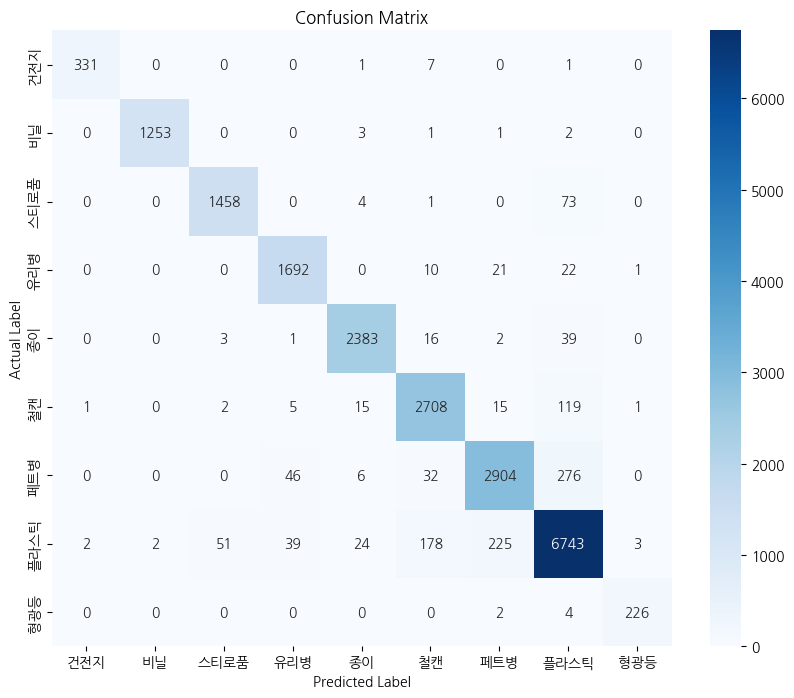

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def get_predictions_and_labels(model, test_loader):
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Getting Predictions"):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # 예측값과 라벨을 CPU로 옮겨 리스트에 추가
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_preds, all_labels

# 1. 예측값 및 실제 라벨 가져오기 ---
y_pred, y_true = get_predictions_and_labels(model, dataloaders['test'])

#  2. 클래스 이름 가져오기 ---
CLASS_NAMES = full_dataset_raw.classes 

# 3. Scikit-learn 리포트  ---
print("\n[상세 분류 리포트]")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

#  혼동 행렬 
cm = confusion_matrix(y_true, y_pred)

# 폰트 파일 경로 지정
font_file_path = './NanumGothic.ttf' 

font_prop = fm.FontProperties(fname=font_file_path)
fm.fontManager.addfont(font_file_path)
font_name = font_prop.get_name()

plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()